In [45]:
#Data Handling and pre-processing packages
import sqlite3
from pandas import Series,DataFrame
import pandas as pd


In [46]:
#visualization packages
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [47]:
#Packages for modeling
from patsy import dmatrices
import warnings
warnings.filterwarnings('ignore')
from sklearn import naive_bayes
from sklearn import linear_model
import statsmodels.api as sm

In [48]:
#cross validation package
from sklearn.cross_validation import train_test_split
from sklearn import metrics


# Reading dataset 1 from SQLite database

In [ ]:
#Connecting to sqlite database and executing sql commands to extract databases of interest
conn=sqlite3.connect("contentDiscovery.db")
articles = pd.read_sql_query("SELECT * from articles", conn)
email_content=pd.read_sql_query("SELECT * from email_content",conn)
types=pd.read_sql_query("SELECT * from types",conn)
users=pd.read_sql_query("SELECT * from users",conn)
topics=pd.read_sql_query("SELECT * from topics",conn)
articles_user_join=pd.read_sql_query("SELECT user_id,count(article_id) from email_content group by user_id",conn)
join_email_article=pd.read_sql_query("SELECT email_content.user_id,email_content.article_id,email_content.send_time,articles.topic_id,articles.type_id,articles.author_id,articles.submission_time from email_content,articles where articles.article_id=email_content.article_id ",conn)
conn.close()

# Reading dataset 2 from apache file

In [12]:
#extracting data from apache file and using string manipulation techniques to extract features of interest
data=pd.read_csv("access.log",header=None)
time=data[0].str.split('"GET',expand=True)
time=time[0]
article_id=data[0].str.split('&user_id',expand=True)
article_id=article_id[0].str.split('=',expand=True)
article_id=article_id[1]
user_id=data[0].str.split('HTTP',expand=True)
user_id=user_id[0].str.split('user_id=',expand=True)
user_id=user_id[1]

In [13]:
#creating the final dataframe of clicks of links
data['article_id']=article_id
data['user_id']=user_id
data['time']=time
data=data.drop(0,1)
data['user_id']=data['user_id'].astype(float)
data['article_id']=data['article_id'].astype(float)
#adding a target variable; Target is 1 if the user clicked the article and it is 0 if user didn't click the article. Since
#this database contains all the clicks, all the target values are 1
data['target']=1  

# Designing training data

Ideally the training data should have information such as the article, user
type,topic, month, time and if the article was read or not which is given in the 
target feature that we created

In [14]:
trainingdata=pd.merge(join_email_article,data,on=['user_id','article_id'],how='left')
#performing a left join to merge the click of links dataset and the email links dataset. 
trainingdata['target']=trainingdata['target'].fillna(0)
#Setting all the target values that are empty as a resulting of joining to 0; these are user_id 
#and article_id combinations that haven't been clicked
trainingdata['time']=trainingdata['time'].fillna(0)
trainingdata.shape

(10746772, 9)

In [15]:
trainingdata.head()
#we need to extract relevant feature of time for analysis. I have made a hypothesis that 
#trends change significantly over a month. If the changes are massive, we can drill down to weekly data and daily data
#If not we can stick with analysis on monthly data

,user_id,article_id,send_time,topic_id,type_id,author_id,submission_time,time,target
0,11460,66,2015-01-02 08:06:20.070850,72,22,18587,2015-01-01 08:37:35.202464,0,0
1,11460,135,2015-01-02 08:06:20.070850,39,25,12121,2015-01-01 13:00:09.427579,0,0
2,11460,175,2015-01-02 08:06:20.070850,91,13,946,2015-01-01 15:09:33.957804,0,0
3,11460,205,2015-01-02 08:06:20.070850,94,23,798,2015-01-01 17:28:56.236504,0,0
4,11460,218,2015-01-02 08:06:20.070850,7,49,17423,2015-01-01 18:56:20.937220,[02/Jan/2015:18:09:06],1


In [ ]:
#Since I have decided to analyze monthly data, I am removing day and year and only extracting month in feature 'month_send_time'
#month_send_time holds values of the month in which the article was sent
month_send_time=trainingdata['send_time']
month_send_time=trainingdata['send_time'].str.split('-',expand=True)
month_send_time=month_send_time[1]
trainingdata['month_send_time']=month_send_time
trainingdata['month_send_time']=month_send_time

In [ ]:
#saving training data to a csv file for ease of import and use
trainingdata.to_csv("finaltrainingdata2.csv")

# Exploratory Data Analysis

In [6]:
#reading the main training data which was created and saved in the pre-processing stage
df=pd.read_csv("finaltrainingdata2.csv")

In [7]:
#calculating total number of users
df=df.drop('Unnamed: 0',1)
df['user_id'].value_counts().count()

20000

In [68]:
#calculating total number of authors
#it is found that less than 5% of the users are authors who contribute to articles
df['author_id'].value_counts().count()

1202

In [8]:
#grouping data by month for analysis of trends over the three months

df_month_3=df[df['month_send_time']==3] # segmenting data of month 3
df_month_2=df[df['month_send_time']==2] # segmenting data of month 2
df_month_1=df[df['month_send_time']==1] # segmenting data of month 1






20000
20000
20000
181
169
186


In [9]:
#segmenting each of the monthly grouped data by target feature 1 (only data of links that were read there were in each month)
data_target_1=df[df['target']==1]

df_month_1_target_1=df_month_1[df_month_1['target']==1]
df_month_2_target_1=df_month_2[df_month_2['target']==1]
df_month_3_target_1=df_month_3[df_month_3['target']==1]


20000
20000
20000


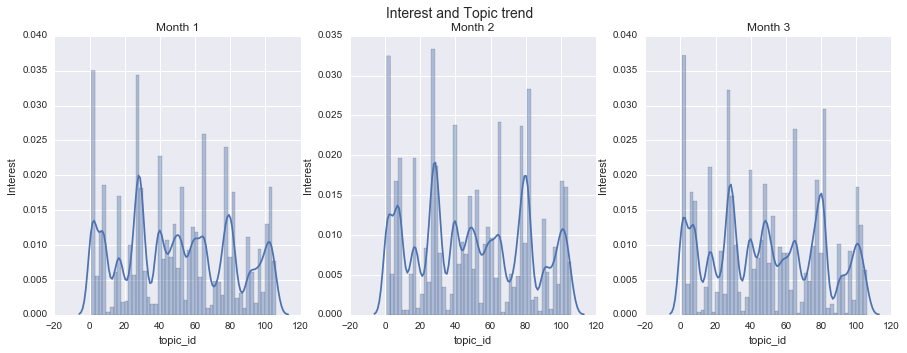

In [23]:
#Plotting interest of over all users over topic. Interest is measured as the total count of articles in that topic that was read
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
sns.distplot(df_month_1_target_1['topic_id'],ax=axis1)
sns.distplot(df_month_2_target_1['topic_id'],ax=axis2)
sns.distplot(df_month_3_target_1['topic_id'],ax=axis3)
axis1.set_title('Month 1')
axis2.set_title('Month 2')
axis3.set_title('Month 3')
axis1.set_ylabel('Interest')
axis2.set_ylabel('Interest')
axis3.set_ylabel('Interest')
fig.suptitle('Interest and Topic trend',fontsize=14)
fig.savefig('Interest_in_topic_trend.png')

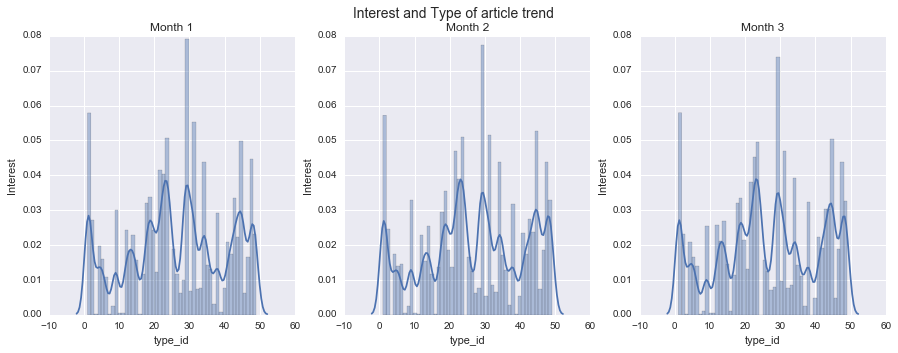

In [33]:
#Plotting interest of over all users over type of article. 
#Interest is measured as the total count of articles in that type that was read
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
sns.distplot(df_month_1_target_1['type_id'],ax=axis1)
sns.distplot(df_month_2_target_1['type_id'],ax=axis2)
sns.distplot(df_month_3_target_1['type_id'],ax=axis3)
axis1.set_title('Month 1')
axis2.set_title('Month 2')
axis3.set_title('Month 3')
axis1.set_ylabel('Interest')
axis2.set_ylabel('Interest')
axis3.set_ylabel('Interest')
fig.suptitle('Interest and Type of article trend',fontsize=14)
fig.savefig('Interest_in_type_trend.png')

In [ ]:
#The patterns look very similar in plots for topic and type which show that interest level doesn't seem to have drastically changed 
#over time

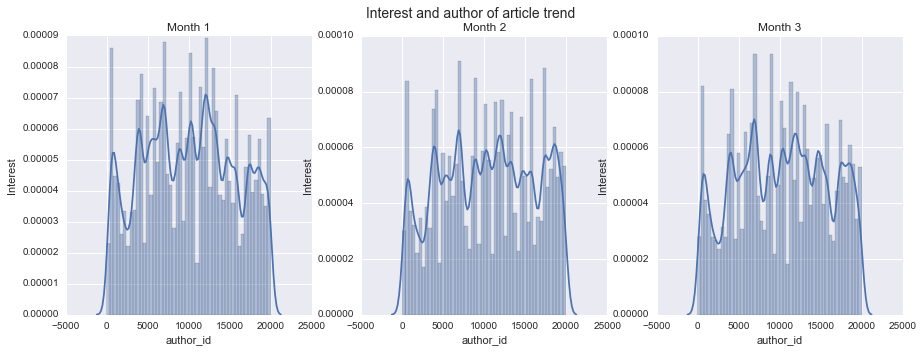

In [34]:
#Plotting interest of over all users over the author of article. 
#Interest is measured as the total count of articles from the particular author that was read
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
sns.distplot(df_month_1_target_1['author_id'],ax=axis1)
sns.distplot(df_month_2_target_1['author_id'],ax=axis2)
sns.distplot(df_month_3_target_1['author_id'],ax=axis3)
axis1.set_title('Month 1')
axis2.set_title('Month 2')
axis3.set_title('Month 3')
axis1.set_ylabel('Interest')
axis2.set_ylabel('Interest')
axis3.set_ylabel('Interest')
fig.suptitle('Interest and author of article trend',fontsize=14)
fig.savefig('Interest_in_author_trend.png')

# DATA MODELING

In [4]:
#Way we approach: find likelihood on month 1. use the same model to predict that for month 2 and 3. 
#if the same model predicts if the link will be read or not with a high accuracy, it means that not much 
#changes have happened in that  month from the previous month

In [79]:
df=pd.read_csv("finaltrainingdata2.csv")

In [7]:
df.head()

,Unnamed: 0,user_id,article_id,topic_id,type_id,author_id,time,target,month_send_time,submission_month
0,0,11460,66,72,22,18587,0,0,1,1
1,1,11460,135,39,25,12121,0,0,1,1
2,2,11460,175,91,13,946,0,0,1,1
3,3,11460,205,94,23,798,0,0,1,1
4,4,11460,218,7,49,17423,[02/Jan/2015:18:09:06],1,1,1


In [8]:
df=df.drop('Unnamed: 0',1)

In [25]:
#ensuring that every feature is treated as a categorical variable while modeling
df['user_id']=df['user_id'].astype('category')
df['article_id']=df['article_id'].astype('category')
df['topic_id']=df['topic_id'].astype('category')
df['type_id']=df['type_id'].astype('category')
df['author_id']=df['author_id'].astype('category')
df['month_send_time']=df['month_send_time'].astype('category')
df['target']=df['target'].astype('category')

In [26]:
formula='target~user_id+author_id+topic_id+type_id+month_send_time' 
#article id has been ommitted as it is not the same for
#every month and wont work with our approach
model=naive_bayes.MultinomialNB()

In [27]:
Y,X=dmatrices(formula,df,return_type='dataframe')
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [28]:
nb1=model.fit(X_train,Y_train)

C:\Users\Reshma\Anaconda1\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
predval=nb1.predict(X_test)

In [33]:
print metrics.accuracy_score(Y_test,predval)

0.540058354267


In [ ]:
#Since we are getting an accuracy of only 54%, let us try another model - the logistic model. 
logreg=linear_model.LogisticRegression()

In [36]:
X=df
Y=X['target']
X=X.drop('target',1)
X=X.drop('time',1)
X=X.drop('article_id',1)
X=X.drop('submission_month',1)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [37]:
logisticmodel=logreg.fit(X_train,Y_train)
pred_y=logisticmodel.predict(X_test)
#confusion_matrix(pred_y,Y_test)

In [38]:
metrics.accuracy_score(Y_test,pred_y)

0.8360162474834304

In [44]:
#Since the logistic model gives us an accuracy of around 83% we can trust the likelihood values of this model.

In [53]:
#Let us make the  assumption that there is no change in trends in terms of reading articles i.e people's likelihoods
#are not affected by time. In this case, the same model we used to predict likelihoods would accurately 

In [ ]:
#let us model logistic regression over month 1  and see its performance on month 2 and month 3 data
#this would help us assess the changes that happened

In [56]:
df_month_1=df[df['month_send_time']==1]

In [30]:
X=df_month_1
Y=X['target']
X=X.drop('target',1)
X=X.drop('time',1)
X=X.drop('month_send_time',1)
X=X.drop('submission_month',1)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=42)
logisticmodel2=logreg.fit(X_train,Y_train)
pred_y1=logisticmodel2.predict(X_test)
#confusion_matrix(pred_y,Y_test)
metrics.accuracy_score(Y_test,pred_y1)

0.83511557118495805

In [31]:
logisticmodel2.coef_

array([[ -2.79555120e-05,  -9.86135133e-05,  -6.87347700e-03,
         -1.31291131e-02,  -3.19482490e-05]])

In [58]:
df_month_2=df[df['month_send_time']==2]
month_2_values=df_month_2['target']
df_month_2=df_month_2.drop('target',1)
df_month_2=df_month_2.drop('time',1)
df_month_2=df_month_2.drop('month_send_time',1)
df_month_2=df_month_2.drop('submission_month',1)
predicted_values=logisticmodel2.predict(df_month_2)

In [59]:
metrics.accuracy_score(month_2_values,predicted_values)

0.83685866437063594

In [60]:
#since the accuracy is almost the same in the next month, looks like nothing has changed over one month! 

In [61]:
#Let us if this is the same case for month 2

In [62]:
df_month_3=df[df['month_send_time']==3]
month_3_values=df_month_3['target']
df_month_3=df_month_3.drop('target',1)
df_month_3=df_month_3.drop('time',1)
df_month_3=df_month_3.drop('month_send_time',1)
df_month_3=df_month_3.drop('submission_month',1)
predicted_values=logisticmodel2.predict(df_month_3)
metrics.accuracy_score(month_3_values,predicted_values)

0.83614462671576828

In [63]:
#again, looks like not much change has happened from the first to the third month. 
#let us model using statsmodel to see which are most significat features. Separate models on all three months would
#show us if significance level has changed or not.

In [40]:
X=df_month_1
Y=X['target']
X=X.drop('target',1)
X=X.drop('time',1)
X=X.drop('article_id',1)
X=X.drop('month_send_time',1)
X=X.drop('submission_month',1)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=42)
logit1=sm.Logit(Y_train,X_train)

In [41]:
result1=logit1.fit()

Optimization terminated successfully.
         Current function value: 0.459225
         Iterations 5


In [42]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:              2716246
Model:                          Logit   Df Residuals:                  2716242
Method:                           MLE   Df Model:                            3
Date:                Fri, 15 Jan 2016   Pseudo R-squ.:                -0.02607
Time:                        22:42:07   Log-Likelihood:            -1.2474e+06
converged:                       True   LL-Null:                   -1.2157e+06
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
user_id    -3.431e-05   2.45e-07   -140.112      0.000     -3.48e-05 -3.38e-05
topic_id      -0.0080   4.74e-05   -169.472      0.000        -0.008    -0.008
type_id       -0.0157   9.75e-05   -161.233      0.000        -0.016    -0.016
author_id  -3.951e-05   2.52e-07   -156.549      0.000        -4e-05  -3.9e-05
==============================================================================
"""

In [33]:
# P values are all close to 0 which shows all are significant; The above is the case for month 1
#The order of significant is as follows: topic_id, type_id, author_id, user_id

In [43]:
X=df_month_2
Y=X['target']
X=X.drop('target',1)
X=X.drop('time',1)
X=X.drop('article_id',1)
X=X.drop('month_send_time',1)
X=X.drop('submission_month',1)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=42)
logit2=sm.Logit(Y_train,X_train)
result=logit2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.457192
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:              2543520
Model:                          Logit   Df Residuals:                  2543516
Method:                           MLE   Df Model:                            3
Date:                Fri, 15 Jan 2016   Pseudo R-squ.:                -0.02722
Time:                        22:43:19   Log-Likelihood:            -1.1629e+06
converged:                       True   LL-Null:                   -1.1321e+06
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
user_id    -3.476e-05   2.54e-07   -137.046      0.000     -3.53e-05 -3.43e-05
topic_id      -0.0078   4.89e-05   -158.562      0.000        -0.008    -0.008
type_id       -0.0164      0.000   -163.666      0.000        -0.017    -0.016
author_id   -3.77e-05   2.55e-07   -147.630      0.000     -3.82e-05 -3.72e-05
==============================================================================
"""

In [35]:
# in the above model, the order of significant predictors based on z values is type_id, topic_id,author_id,user_id

In [44]:
X=df_month_3
Y=X['target']
X=X.drop('target',1)
X=X.drop('time',1)
X=X.drop('article_id',1)
X=X.drop('month_send_time',1)
X=X.drop('submission_month',1)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=42)
logit3=sm.Logit(Y_train,X_train)
result=logit3.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.459411
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:              2800312
Model:                          Logit   Df Residuals:                  2800308
Method:                           MLE   Df Model:                            3
Date:                Fri, 15 Jan 2016   Pseudo R-squ.:                -0.02976
Time:                        22:45:18   Log-Likelihood:            -1.2865e+06
converged:                       True   LL-Null:                   -1.2493e+06
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
user_id    -3.599e-05   2.41e-07   -149.193      0.000     -3.65e-05 -3.55e-05
topic_id      -0.0076   4.67e-05   -161.629      0.000        -0.008    -0.007
type_id       -0.0158    9.5e-05   -166.463      0.000        -0.016    -0.016
author_id  -3.985e-05   2.45e-07   -162.609      0.000     -4.03e-05 -3.94e-05
==============================================================================
"""

In [ ]:
# in the above model, the order of significant predictors based on z values is type_id, topic_id,author_id,user_id